# Hackathon Saturday, March 28, 2020

In [1]:
ls

COVID.DATA.LIC.AGMT.pdf* comm_use_subset/         metadata.csv*
Untitled.ipynb           custom_license/          metadata.readme*
biorxiv_medrxiv/         json_schema.txt*         noncomm_use_subset/


> Import libraries

In [218]:
import glob
import json
import re
import spacy

from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

# spacy models
nlp_vecs = spacy.load('en_core_sci_md')
nlp = spacy.load('en_ner_bc5cdr_md')

> `ben.batorsky`'s help

In [75]:
all_json = glob.glob(f'**/*.json', recursive=True)

In [79]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
                
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)


def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

86a998617c077f4fe2ab26214995a3548fbc0fc5: The recent emergence of the Middle East respiratory syndrome (MERS)-CoV, a close relative of the Severe Acute respiratory syndrome (SARS)-CoV, both of which caused a lethal respiratory infection in hu... While most CoVs cause the common cold in humans, infection with two recently emerged CoVs, SARS-CoV and MERS-CoV, resulted in more severe pulmonary disease with alarmingly high case fatality rates [1]...


> make `df_covid`

In [83]:
dict_ = {'paper_id': [], 
         'abstract': [], 
         'body_text': [], 
         'authors': [], 
         'title': [], 
         'journal': [], 
         'abstract_summary': []}

# for each json file
for idx, entry in enumerate(all_json):
    
    # print every 10%
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
        
    # read the file
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        

    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 33375
Processing index: 3337 of 33375
Processing index: 6674 of 33375
Processing index: 10011 of 33375
Processing index: 13348 of 33375
Processing index: 16685 of 33375
Processing index: 20022 of 33375
Processing index: 23359 of 33375
Processing index: 26696 of 33375
Processing index: 30033 of 33375
Processing index: 33370 of 33375


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,,The evolutionary history of humans is characte...,"Scarpino, S.V.",Evolutionary Medicine IV. Evolution and<br>Em...,Encyclopedia of Evolutionary Biology,Not provided.
1,6599ebbef3d868afac9daa4f80fa075675cf03bc,"International aviation is growing rapidly, res...","Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew. Wallace, Lailey",International aviation emissions to 2025: Can...,Energy Policy,"International aviation is growing rapidly,<br..."
2,eb5c7f3ff921ad6469b79cc8a3c122648204ece4,,Acute infections of the gastrointestinal tract...,"Booth, I.W.. McNeish, A.S.",Mechanisms of diarrhoea,Baillière's Clinical Gastroenterology,Not provided.
3,b87b790c96c75faa22a085cb560f7b3d8e018b24,,"There are three domains of life-Bacteria, Arch...","Louten, Jennifer",Chapter 3 Features of Host Cells Cellular and...,Essential Human Virology,Not provided.
4,68c0bb1989b6ca2b38da32a0d992027db39f80bc,Hong Kong's new Police Commissioner Chris Tang...,"It is also noteworthy that Tang, who was once ...","Hui, Victoria Tin-bor",Beijing's Hard and Soft Repression in Hong Kong,Orbis,Hong Kong's new Police Commissioner Chris Tan...


## Parse abstracts using `spacy`

In [219]:
# parsed_abstracts = [d for d in nlp.pipe(df_covid.abstract)]
parsed_abstracts_np_bvecs = [d for d in nlp_vecs.pipe(df_covid.abstract)]


In [222]:
# make an inventory of all entities
ent_count = defaultdict(int)
for d in parsed_abstracts:
    for e in d.ents:
        ent_count[(e.text, e.label_)]+=1

ent_count_nlp_vecs = defaultdict(int)
for d in parsed_abstracts_np_bvecs:
    for e in d.ents:
        ent_count_nlp_vecs[(e.text, e.label_)]+=1


In [228]:
count_df = pd.DataFrame.from_dict(ent_count, orient='index').reset_index()

count_df['word'] = count_df['index'].str[0]
count_df['group'] = count_df['index'].str[1]
count_df['spacy model'] = 'en_ner_bc5cdr_md'
count_df = count_df.drop('index', axis=1)

count_df.columns = ['count', 'word', 'group', 'spacy model']

# count_df.columns = ['count', 'word', 'group']

count_df = count_df.sort_values(by='count', ascending=False)
count_df.head(n=10)

,count,word,group,spacy model
54,6229,infection,DISEASE,en_ner_bc5cdr_md
16,3459,SARS,DISEASE,en_ner_bc5cdr_md
56,1705,infections,DISEASE,en_ner_bc5cdr_md
212,1500,pneumonia,DISEASE,en_ner_bc5cdr_md
305,1490,diarrhea,DISEASE,en_ner_bc5cdr_md
210,1274,infectious diseases,DISEASE,en_ner_bc5cdr_md
164,1117,death,DISEASE,en_ner_bc5cdr_md
100,948,viral infection,DISEASE,en_ner_bc5cdr_md
174,900,fever,DISEASE,en_ner_bc5cdr_md
224,871,amino acid,CHEMICAL,en_ner_bc5cdr_md


In [227]:
count_df_vec = pd.DataFrame.from_dict(ent_count_nlp_vecs, orient='index').reset_index()

count_df_vec['word'] = count_df_vec['index'].str[0]
count_df_vec['group'] = count_df_vec['index'].str[1]
count_df_vec['spacy model'] = 'en_core_sci_md'

count_df_vec = count_df_vec.drop('index', axis=1)
count_df_vec.columns = ['count', 'word', 'group', 'spacy model']

count_df_vec = count_df_vec.sort_values(by='count', ascending=False)
count_df_vec.head(n=20)

,count,word,group,spacy model
98,9752,patients,ENTITY,en_core_sci_md
85,9407,study,ENTITY,en_core_sci_md
678,6707,human,ENTITY,en_core_sci_md
819,5945,infection,ENTITY,en_core_sci_md
485,4920,viruses,ENTITY,en_core_sci_md
113,4820,data,ENTITY,en_core_sci_md
194,4710,results,ENTITY,en_core_sci_md
493,4583,associated with,ENTITY,en_core_sci_md
448,4150,expression,ENTITY,en_core_sci_md
645,4063,virus,ENTITY,en_core_sci_md


Text(0.5, 1.05, 'Most common words in the abstracts (Top 25)')

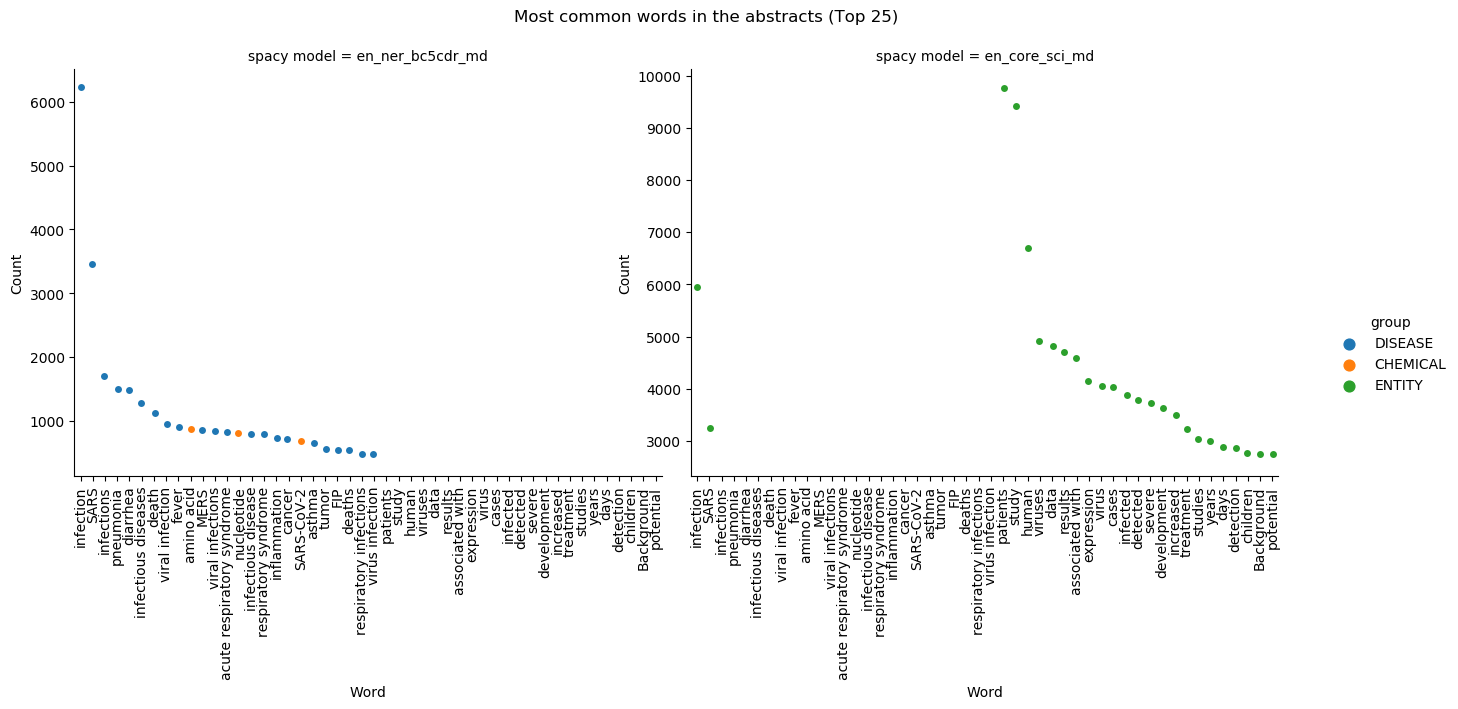

In [255]:
count_df_all = pd.concat([count_df[:25], count_df_vec[:25]], axis=0)

g = sns.catplot(x='word', y='count', hue='group', col='spacy model', sharey=False, data=count_df_all[:50])

g.fig.set_size_inches(15,5)
g.fig.set_dpi(100)

g.fig.show()

for ax in np.ravel(g.axes):
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('Word')
    ax.set_ylabel('Count')
#     g._legend.set_title('Spacy label')

g.fig.subplots_adjust(wspace=0.05)
g.fig.suptitle("Most common words in the abstracts (Top 25)", y=1.05)

Text(0.5, 1.0, 'Most common words in the abstracts (Top 50) \nspacy - en_core_sci_md label')

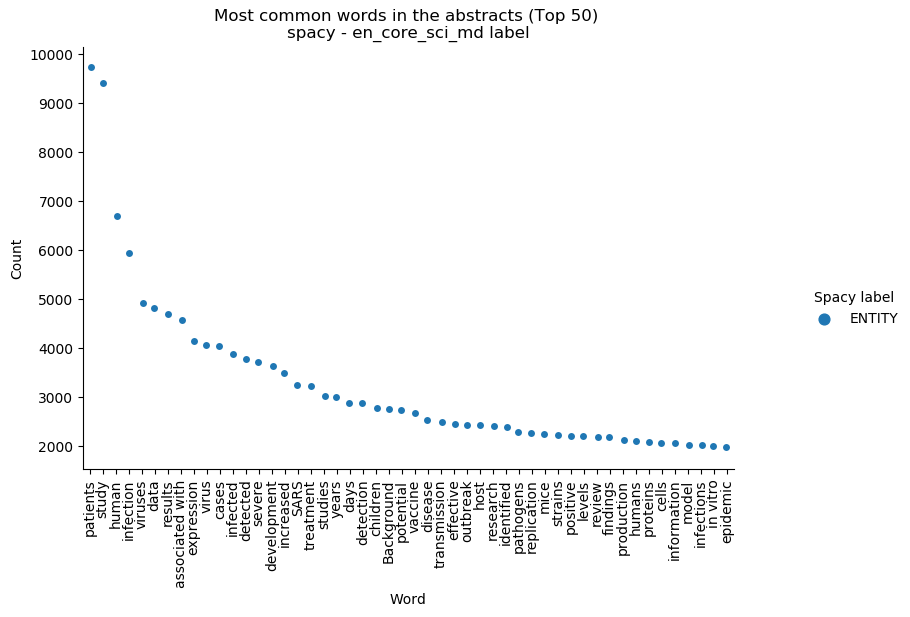

In [256]:
g = sns.catplot(x='word', y='count', hue='group', data=count_df_vec[:50])
g.fig.set_size_inches(10,5)
g.fig.set_dpi(100)

g.ax.set_xticklabels(labels=g.ax.get_xticklabels(), rotation=90)
g.fig.show()
g.ax.set_xlabel('Word')
g.ax.set_ylabel('Count')
g._legend.set_title('Spacy label')
g.ax.set_title("Most common words in the abstracts (Top 50) \nspacy - en_core_sci_md label")

Text(0.5, 1.0, 'Most common words in the abstracts (Top 50) \nspacy - en_ner_bc5cdr_md label')

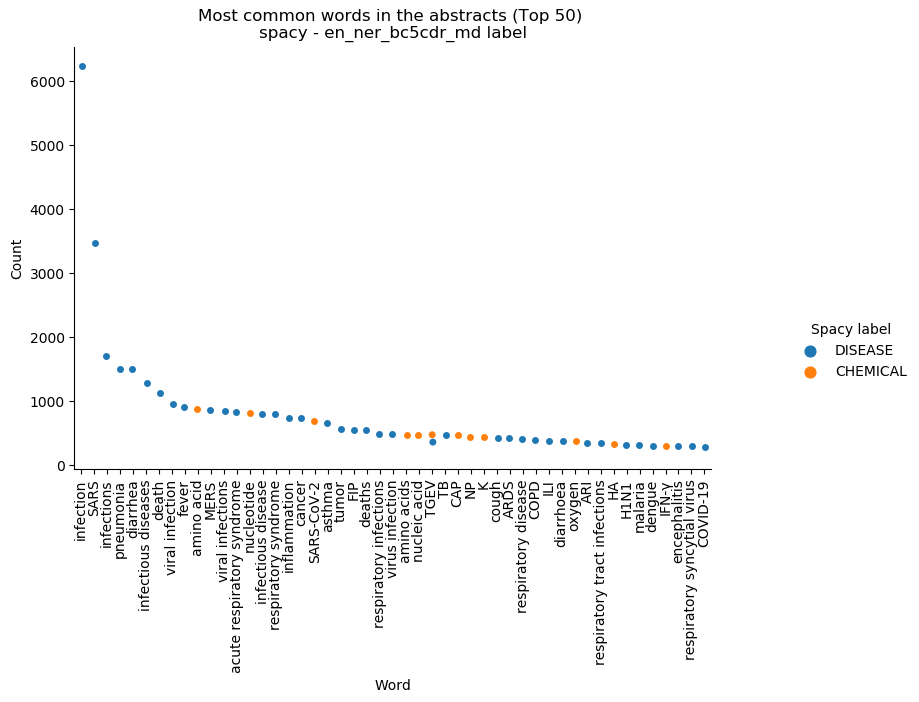

In [138]:
g = sns.catplot(x='word', y='count', hue='group', data=count_df[:50])
g.fig.set_size_inches(10,5)
g.fig.set_dpi(100)

g.ax.set_xticklabels(labels=g.ax.get_xticklabels(), rotation=90)
g.fig.show()
g.ax.set_xlabel('Word')
g.ax.set_ylabel('Count')
g._legend.set_title('Spacy label')
g.ax.set_title("Most common words in the abstracts (Top 50) \nspacy - en_ner_bc5cdr_md label")

# Authors

In [215]:
all_authors = []
for index, row in df_covid.iterrows():
    try:
        study_authors_list = [x.strip() for x in row.authors.split(',')]
        study_authors_dict[index] = study_authors_list
        all_authors += study_authors_list
    except:
        study_authors_dict[index] = []
        
        
authors_all = pd.DataFrame({'authors':all_authors})

author_count_in_all_papers = authors_all.authors.value_counts().reset_index()

,index,authors
55232,Jianyu...,1
55233,Nicola Di,1
55234,H.. Joachim,1
55235,Paul R.. Blanc,1
55236,Wenzhong...,1
55237,Mengni...,1
55238,Blumer,1
55239,Andreas. Klinkenberg,1
55240,Afrasiabi,1
55241,Huma. Nawaz,1


In [217]:
author_count_in_all_papers.head(10)

,index,authors
0,Wang,470
1,Li,358
2,Zhang,355
3,Chen,328
4,Liu,266
5,Lee,251
6,Kim,214
7,Yang,166
8,Wu,157
9,Zhao,138


In [216]:
author_count_in_all_papers.tail(10)

,index,authors
55232,Jianyu...,1
55233,Nicola Di,1
55234,H.. Joachim,1
55235,Paul R.. Blanc,1
55236,Wenzhong...,1
55237,Mengni...,1
55238,Blumer,1
55239,Andreas. Klinkenberg,1
55240,Afrasiabi,1
55241,Huma. Nawaz,1


/Users/kevin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


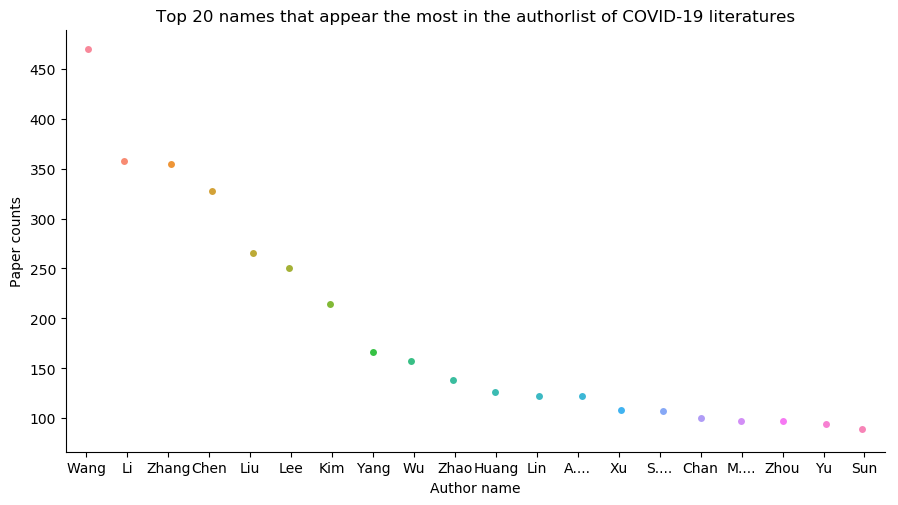

In [211]:
g = sns.catplot(x='index', y='authors', data=author_count_in_all_papers[:20])
g.fig.set_size_inches(10,5)
g.fig.set_dpi(100)
g.ax.set_title('Top 20 names that appear the most in the authorlist of COVID-19 literatures')
g.ax.set_ylabel('Paper counts')
g.ax.set_xlabel('Author name')

g.fig.show()

# Journals

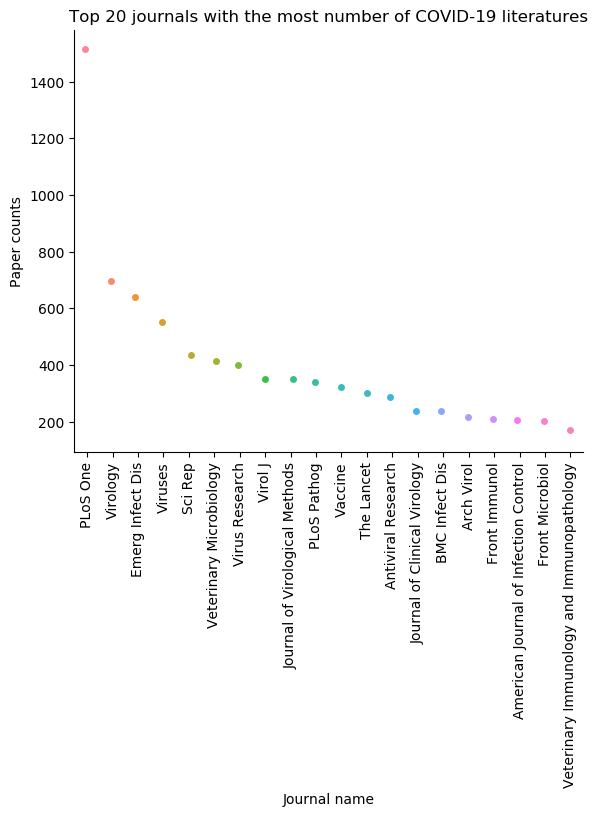

In [266]:
journal_count = df_covid.journal.value_counts().reset_index()

# journal_count
g = sns.catplot(x='index', y='journal', data=journal_count[:20])
g.fig.set_size_inches(10,5)
g.fig.set_dpi(100)
g.ax.set_title('Top 20 journals with the most number of COVID-19 literatures')
g.ax.set_ylabel('Paper counts')
g.ax.set_xlabel('Journal name')
g.ax.set_xticklabels(labels=g.ax.get_xticklabels(), rotation=90)
g.fig.show()

---

# IGNORE BELOW

---

> README file

In [2]:
!cat metadata.readme

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)
	- CZI 1236 records
	- PMC 27337
	- bioRxiv 566
	- medRxiv 361
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'
(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.
(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)
(5) Various 'keys' are populated with the metadata:
	- 'pmcid': populated for all PMC paper records (27337 non null)
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)
	- 'pubmed_id': populated for some of the records
	- 'Microsoft Academic Paper ID': populated for some of the records


> import libraries

In [66]:
import spacy
import numpy as np
import pandas as pd

> load data

In [82]:
meta_df = pd.read_csv('metadata.csv',
                dtype={'abstract':str})

In [24]:
df.shape

(45774, 17)

> Cannot use all of the dataframe - my laptop is not good enough

In [54]:
df = df[:1000]

> Apply spacy `en_ner_bc5cdr_md` to the abstract

In [55]:
# select the dataframe with the abstract
df_abstract_exist = df[~df.abstract.isnull()]

In [56]:
# parse abstracts
parsed_abstracts = [d for d in nlp.pipe(df_abstract_exist.abstract)]

In [60]:
a = parsed_abstracts[0]

In [63]:
a.vector

array([-0.00664037, -0.03799947,  0.12215851, -0.04205997,  0.05514101,
       -0.01582563, -0.04606913, -0.05869741, -0.01835955, -0.01618209,
        0.02787624, -0.12689734,  0.05034321, -0.02511196,  0.00064907,
       -0.0158342 , -0.04147159, -0.12659045,  0.05534204,  0.07809938,
       -0.02234354, -0.08265593,  0.03838056, -0.07826717, -0.00797987,
        0.03903595,  0.04331673, -0.07785049,  0.03483844,  0.09152719,
       -0.01285068, -0.14885828, -0.02623676,  0.01865657,  0.09595247,
        0.07585918,  0.00591203,  0.05994117, -0.11694781, -0.04508989,
        0.00567531,  0.02404428,  0.01749603,  0.01484689,  0.03037765,
       -0.02768262, -0.11686211, -0.12894098,  0.01021313, -0.15124129,
        0.01370382,  0.08506086, -0.01542391,  0.03145294,  0.0297431 ,
        0.01550827,  0.01039152,  0.07893658,  0.02884072, -0.01502201,
       -0.00121737, -0.01938723, -0.01884189,  0.00109767,  0.04519816,
        0.0057025 ,  0.0237354 ,  0.03257579,  0.02841   , -0.02

In [38]:
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url,parse
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727,<generator object Language.pipe at 0x2e09f67c8>
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889,<generator object Language.pipe at 0x2e09f6750>
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866,<generator object Language.pipe at 0x2e09f68b8>
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476,<generator object Language.pipe at 0x2e09f6930>
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389,<generator object Language.pipe at 0x2e09f69a8>


In [7]:
nlp = spacy.load('en_ner_bc5cdr_md')
nlp_ner = spacy.load('en_ner_bionlp13cg_md')
nlp_vecs = spacy.load('en_core_sci_md')
abstract = """Out of the plethora of chemical species extractable at low levels from the materials of construction of single-use bioprocess containers, we have identified one particularly conspicuous compound and shown it to be highly detrimental to cell growth. The compound, bis(2,4-di-tert-butylphenyl)phosphate (bDtBPP)"""
abstract
parsed = nlp(abstract)


[(bis(2,4-di-tert-butylphenyl)phosphate, 'CHEMICAL'), (bDtBPP, 'CHEMICAL')]

In [10]:
abstract = """Objectives: Alterations in thalamocortical anatomical connectivity, specifically the connection between the orbitofrontal cortex and thalamus, have been frequently reported in schizophrenia and are suggested to contribute to the pathophysiology of schizophrenia. The connectivity of the thalamocortical white matter in unaffected relatives of schizophrenia patients was compared to that of healthy controls. Methods: The unaffected relative group was defined as asymptomatic family members who had at least one first-degree relative with schizophrenia and one or more other affected first- to third-degree relatives. A total of 35 unaffected relatives and 34 healthy controls underwent diffusion-weighted and T1-weighted magnetic resonance imaging to examine the white matter connectivity between the thalamus and orbitofrontal cortex using probabilistic tractography. Results: After controlling for age and sex, the unaffected relatives exhibited significantly reduced fractional anisotropy values for the left thalamo-orbitofrontal tract compared to that of healthy controls, F(1, 65) = 6.93, p = 0.011, effect size partial η2 = 0.10. However, there was no association between the Genetic Liability Score and fractional anisotropy in the left thalamo-orbitofrontal tracts. Conclusion: Our findings in the unaffected relatives of schizophrenia patients, which are in line with the alterations reported in schizophrenia, first-episode psychosis and clinical high risk for psychosis, highlight a possible genetic contribution to the proposed biomarker of altered thalamocortical connectivity."""

In [11]:
print(abstract)

Objectives: Alterations in thalamocortical anatomical connectivity, specifically the connection between the orbitofrontal cortex and thalamus, have been frequently reported in schizophrenia and are suggested to contribute to the pathophysiology of schizophrenia. The connectivity of the thalamocortical white matter in unaffected relatives of schizophrenia patients was compared to that of healthy controls. Methods: The unaffected relative group was defined as asymptomatic family members who had at least one first-degree relative with schizophrenia and one or more other affected first- to third-degree relatives. A total of 35 unaffected relatives and 34 healthy controls underwent diffusion-weighted and T1-weighted magnetic resonance imaging to examine the white matter connectivity between the thalamus and orbitofrontal cortex using probabilistic tractography. Results: After controlling for age and sex, the unaffected relatives exhibited significantly reduced fractional anisotropy values f

In [16]:
# parsed = nlp(abstract)
# parsed = nlp_ner(abstract)
parsed = nlp_vecs(abstract)


In [17]:
[(e, e.label_) for e in parsed.ents]

[(Objectives, 'ENTITY'),
 (Alterations, 'ENTITY'),
 (thalamocortical, 'ENTITY'),
 (anatomical, 'ENTITY'),
 (connection, 'ENTITY'),
 (orbitofrontal cortex, 'ENTITY'),
 (thalamus, 'ENTITY'),
 (schizophrenia, 'ENTITY'),
 (pathophysiology, 'ENTITY'),
 (schizophrenia, 'ENTITY'),
 (connectivity, 'ENTITY'),
 (thalamocortical white matter, 'ENTITY'),
 (unaffected, 'ENTITY'),
 (relatives, 'ENTITY'),
 (schizophrenia, 'ENTITY'),
 (patients, 'ENTITY'),
 (healthy controls, 'ENTITY'),
 (unaffected, 'ENTITY'),
 (relative group, 'ENTITY'),
 (asymptomatic, 'ENTITY'),
 (family members, 'ENTITY'),
 (first-degree, 'ENTITY'),
 (schizophrenia, 'ENTITY'),
 (affected, 'ENTITY'),
 (third-degree relatives, 'ENTITY'),
 (unaffected, 'ENTITY'),
 (relatives, 'ENTITY'),
 (healthy controls, 'ENTITY'),
 (diffusion-weighted, 'ENTITY'),
 (T1-weighted magnetic resonance imaging, 'ENTITY'),
 (white matter, 'ENTITY'),
 (connectivity, 'ENTITY'),
 (thalamus, 'ENTITY'),
 (orbitofrontal cortex, 'ENTITY'),
 (probabilistic tract

In [13]:
[(e, e.label_) for e in parsed.ents]

[(schizophrenia, 'DISEASE'),
 (schizophrenia, 'DISEASE'),
 (schizophrenia, 'DISEASE'),
 (schizophrenia, 'DISEASE'),
 (third-degree, 'DISEASE'),
 (F(1, 'CHEMICAL'),
 (schizophrenia, 'DISEASE'),
 (schizophrenia, 'DISEASE'),
 (first-episode psychosis, 'DISEASE'),
 (psychosis, 'DISEASE')]

In [15]:
[(e, e.label_) for e in parsed.ents]

[(orbitofrontal cortex, 'CANCER'),
 (thalamus, 'ORGAN'),
 (patients, 'ORGANISM'),
 (first-, 'SIMPLE_CHEMICAL'),
 (thalamus, 'SIMPLE_CHEMICAL'),
 (orbitofrontal cortex, 'CANCER'),
 (left thalamo-orbitofrontal tract, 'TISSUE'),
 (F(1, 'SIMPLE_CHEMICAL'),
 (left thalamo-orbitofrontal tracts., 'MULTI-TISSUE_STRUCTURE'),
 (patients, 'ORGANISM'),
 (line, 'CELL'),
 (first-episode, 'PATHOLOGICAL_FORMATION')]